In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import cmath
import statsmodels.api as sm
import scipy as sp
%run Functions.ipynb

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

### State vectors and field operators

In [3]:
psi = qt.fock(2,0)

In [4]:
psi

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [5]:
fi = qt.fock(2,1)

Initial conditions:

In [6]:
initial_ket = qt.tensor(psi, fi)

In [7]:
initial_ket

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

Field Operators:

In [7]:
a_1 = qt.tensor(qt.destroy(2), qt.qeye(2))
a_2 = qt.tensor(qt.qeye(2), qt.destroy(2))

In [8]:
b_1 = qt.destroy(2)
b_1*b_1.dag() + b_1.dag()*b_1

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [9]:
b_1*b_1.dag() - b_1.dag()*b_1

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [10]:
N_1 = a_1.dag()*a_1
N_2 = a_2.dag()*a_2

Let's show that they behave as fermionic operators

In [8]:
a_2.dag()*initial_ket 

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]

In [9]:
a_2*initial_ket

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [10]:
a_1.dag()*initial_ket

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

In [11]:
a_1*initial_ket

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]

### Hamiltonian

$$ \mathcal{H}_{QDD} = \hbar [\omega_1 a_1^{\dagger}a_1 + \omega_2 a_2^{\dagger}a_2] + \Omega(a_1^{\dagger} a_2 + a_2^{\dagger}a_1)$$

In [15]:
hbar = 1
omega_1 = 0
omega_2 = 0
Omega = 0.3 #Exchange energy 

In [16]:
H = hbar*(omega_1*a_1.dag()*a_1 + omega_2*a_2.dag()*a_2) + hbar*Omega*(a_1.dag()*a_2 + a_2.dag()*a_1)

In [17]:
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.  0.3 0. ]
 [0.  0.3 0.  0. ]
 [0.  0.  0.  0. ]]

### Master Equation

The stochastic master equation has the form

$$ d \rho(t) = -\frac{i}{\hbar}[\mathcal{H_{QDD}}dt, \rho]dt + \mathcal{D}[A] \rho(t)dt + \mathcal{H}[A]\rho(t)dW_t$$
And the superoperators $\mathcal{D}$ and $\mathcal{D}$ are defined by
$$ \mathcal{H}[A] \rho = \frac{1}{2}[2 A \rho A^{\dagger} - \rho A^{\dagger} A - A^{\dagger} A \rho]$$ 
$$
\mathcal{H}[A] \rho = A \rho + \rho A^{\dagger} - Tr[A \rho + \rho A^{\dagger}] $$
with 
$$ A = \frac{T^*}{|T|}(\mathcal{T} + \chi N_1) \;\;.$$

In [20]:
T = 10. #Tunneling coefficient
chi = 0.1 #Tunneling coefficient variation
gamma = abs(chi)/abs(T)
dt = 0.1
times = np.arange(0, 1000000, dt)
NUMBER_OF_TRAJECTORIES = 1

Jump operator:

In [21]:
A =(T + chi*a_1.dag()*a_1)

In [22]:
#noise order
print('noise order', 1/np.sqrt(dt))

noise order 3.162277660168379


In [23]:
#create the density matrix from the initial ket
rho_0 = initial_ket*initial_ket.dag()

In [24]:
rho_0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Current operators

In [25]:
 I = abs(T)*(1 + 2*gamma*np.cos(cmath.phase(T) - cmath.phase(chi))*(a_1.dag()*a_1 - a_2.dag()*a_2))
I_1 = abs(chi)*(a_1.dag()*a_1 - a_2.dag()*a_2) 

In [26]:
I_1

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.  -0.1  0.   0. ]
 [ 0.   0.   0.1  0. ]
 [ 0.   0.   0.   0. ]]

### Simulation

In [26]:
stoc_solution = qt.smesolve(H, rho_0, times,
                            c_ops=[],
                            sc_ops=[A],
                            ntraj=NUMBER_OF_TRAJECTORIES,
                            nsubsteps=100,
                            store_measurement=True,
                            dW_factors=[1.])

10.0%. Run time: 719.70s. Est. time left: 00:01:47:57
20.0%. Run time: 1439.69s. Est. time left: 00:01:35:58
30.0%. Run time: 2154.24s. Est. time left: 00:01:23:46
40.0%. Run time: 2886.82s. Est. time left: 00:01:12:10
50.0%. Run time: 3616.34s. Est. time left: 00:01:00:16
60.0%. Run time: 4331.66s. Est. time left: 00:00:48:07
70.0%. Run time: 5047.93s. Est. time left: 00:00:36:03
80.0%. Run time: 5767.19s. Est. time left: 00:00:24:01
90.0%. Run time: 6489.12s. Est. time left: 00:00:12:01
Total run time: 7206.20s


### Single Trajectory solution

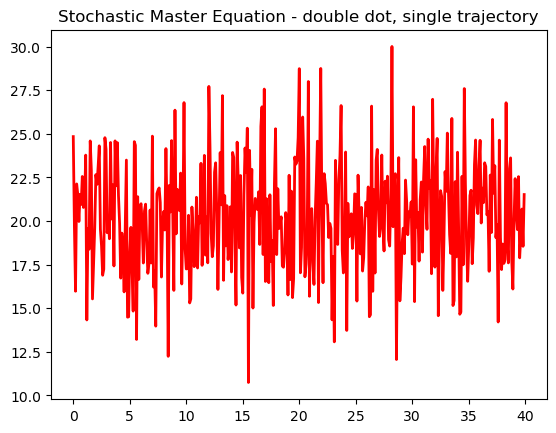

In [28]:
fig, ax = plt.subplots()
ax.set_title('Feedback stochastic Master Equation - double dot, single trajectory')
ax.plot(times,stoc_solution.measurement[12],
        'r', lw=2, label=r'$J_x$')

### Save

In [ ]:
np.savetxt('Single/single.txt', stoc_solution.measurement[0])